In [1]:
from utils import rgb, get_dataset, get_performance
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd
import pickle
from model import TwoNN
import numpy as np
import torch
import copy


plt.style.use(["science", "no-latex", "nature"])


def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how="outer")
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 4)
    return pvalues


# Disparity impact of FL


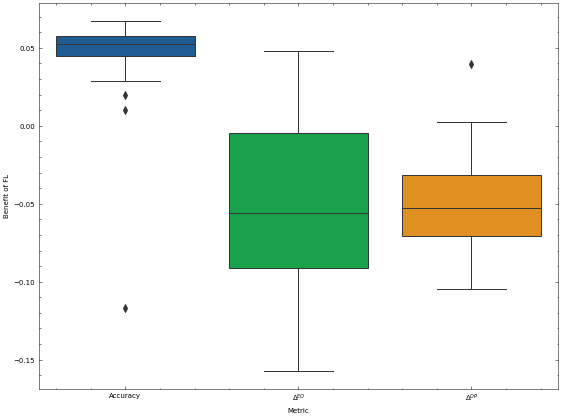

In [2]:
attr_idx = 1  # Sex
res_data = pd.read_csv("saved_information/income_all_information.csv")
res_data["new_gap_acc"] = res_data["FL"] - res_data["Standalone"]
res_data["new_gap_eo"] = res_data["Standalone_eo"] - res_data["FL_eo"]
res_data["new_gap_dp"] = res_data["Standalone_dp"] - res_data["FL_dp"]
plot_data = (
    res_data[res_data["attr"] == attr_idx].groupby(["client"]).mean().reset_index()
)

plt.figure(figsize=(8, 6))
bplot = sns.boxplot(
    x="variable",
    y="value",
    data=pd.melt(plot_data[["new_gap_acc", "new_gap_eo", "new_gap_dp"]]),
)
plt.ylabel("Benefit of FL")
plt.gca().set_xticklabels(labels=["Accuracy", r"$\Delta^{EO}$", r"$\Delta^{DP}$"])
plt.xlabel("Metric")
plt.tight_layout()
plt.show()


<!-- # Figure: propagation path based on the whole influence -->


# Bias propagation in FL


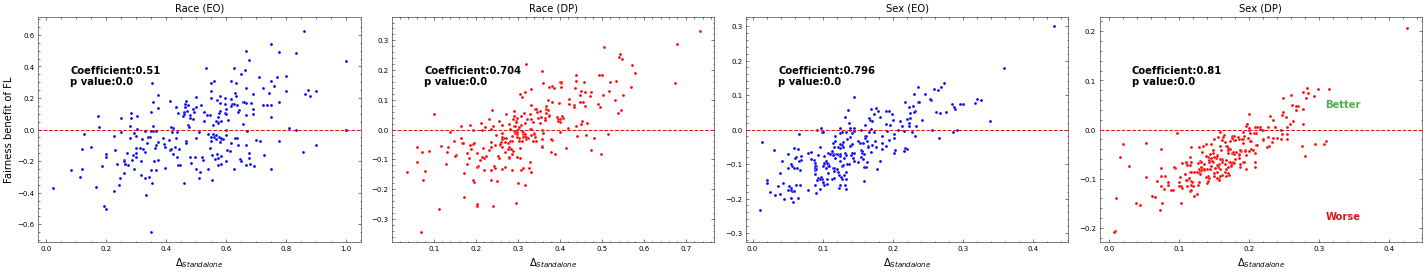

In [3]:
font_size = 10
res_data = pd.read_csv("saved_information/income_all_information.csv")
res_data["new_gap_acc"] = res_data["FL"] - res_data["Standalone"]
res_data["new_gap_eo"] = res_data["Standalone_eo"] - res_data["FL_eo"]
res_data["new_gap_dp"] = res_data["Standalone_dp"] - res_data["FL_dp"]

figs, axes = plt.subplots(1, 4, figsize=(20, 4), sharey=False)
base = 0
for attr_idx in [0, 1]:
    plot_data = res_data[res_data["attr"] == attr_idx]

    sns.scatterplot(
        data=plot_data,
        y="new_gap_eo",
        x="Standalone_eo",
        ax=axes[base + 0],
        color="blue",
        zorder=10,
    )
    sns.scatterplot(
        data=plot_data,
        y="new_gap_dp",
        x="Standalone_dp",
        ax=axes[base + 1],
        color="red",
        zorder=10,
    )

    if attr_idx == 0:
        axes[base + 0].set_title("Race (EO)", fontsize=font_size)
        axes[base + 1].set_title("Race (DP)", fontsize=font_size)
    elif attr_idx == 1:
        axes[base + 0].set_title("Sex (EO)", fontsize=font_size)
        axes[base + 1].set_title("Sex (DP)", fontsize=font_size)
    corr_eo = (
        plot_data[["Standalone_eo", "new_gap_eo"]]
        .corr(method="pearson", min_periods=1)
        .iloc[0, 1]
    )

    corr_dp = (
        plot_data[["Standalone_dp", "new_gap_dp"]]
        .corr(method="pearson", min_periods=1)
        .iloc[0, 1]
    )

    p_value_dp = calculate_pvalues(plot_data[["Standalone_dp", "new_gap_dp"]]).iloc[
        0, 1
    ]
    p_value_eo = calculate_pvalues(plot_data[["Standalone_eo", "new_gap_eo"]]).iloc[
        0, 1
    ]

    for idx, corr, p_value in zip(
        [base + 0, base + 1], [corr_eo, corr_dp], [p_value_eo, p_value_dp]
    ):
        axes[idx].axhline(y=0, color=rgb(215, 25, 28), linestyle="--", zorder=10)
        xmin, xmax = axes[idx].get_xlim()
        ymin, ymax = axes[idx].get_ylim()
        ylim = max(abs(ymin), abs(ymax))
        y = np.arange(-ylim, 0, 0.01)
        y = np.arange(0, ylim, 0.01)
        axes[idx].set_xlim(xmin, xmax)
        axes[idx].set_ylim(-ylim, ylim)
        axes[idx].set_xlabel(r"$\Delta_{Standalone}$", fontsize=font_size)
        axes[idx].text(
            0.1,
            0.7,
            "Coefficient:{}\np value:{}".format(round(corr, 3), round(p_value, 3)),
            color="black",
            weight="bold",
            transform=axes[idx].transAxes,
            fontsize=font_size,
            zorder=15,
        )
        axes[idx].set_ylabel("")
    base += 2

axes[0].set_ylabel("Fairness benefit of FL", fontsize=font_size)
axes[3].text(
    0.7,
    0.1,
    "Worse",
    color=rgb(215, 25, 28),
    weight="bold",
    transform=axes[idx].transAxes,
    fontsize=font_size,
    zorder=15,
)
axes[3].text(
    0.7,
    0.6,
    "Better",
    color=rgb(77, 175, 74),
    weight="bold",
    transform=axes[idx].transAxes,
    fontsize=font_size,
    zorder=15,
)

plt.tight_layout()
plt.show()


# Impact of scaling model parameters


In [4]:
# load the data
random_seed_list = [0, 1, 2, 3, 4]
if os.path.isfile("saved_information/income_scaling_results.csv"):
    all_results_df = pd.read_csv("saved_information/income_scaling_results.csv")

else:
    all_results = {"acc": [], "eo": [], "dp": [], "weight": [], "client": [], "rs": []}
    for random_seed in random_seed_list:
        folder_path = "results/income/run_{}".format(random_seed)
        data_file = "{}/data.pkl".format(folder_path)
        with open(data_file, "rb") as f:  # Python 3: open(..., 'rb')
            dataset = pickle.load(f)

        (
            num_user,
            users,
            train_data_num,
            test_data_num,
            train_data_global,
            test_data_global,
            val_data_global,
            train_data_local_num_dict,
            test_data_local_num_dict,
            train_data_local_dict,
            test_data_local_dict,
            val_data_local_dict,
            class_num,
            unselected_data_local_dict,
        ) = dataset
        test_model = TwoNN(54, 32, 2)
        for client_idx in range(51):
            x, y, s = get_dataset(test_data_local_dict[client_idx])
            weight = 1
            test_weight = copy.deepcopy(torch.load("{}/fedavg.pt".format(folder_path)))
            test_weight["fc1.weight"][:, 43:45] = (
                weight * test_weight["fc1.weight"][:, 43:45]
            )
            test_model.load_state_dict(test_weight)
            acc, eo_gap, dp_gap, _ = get_performance(test_model, x, y, s, 1)
            all_results["acc"].append(acc)
            all_results["eo"].append(eo_gap)
            all_results["dp"].append(dp_gap)
            all_results["weight"].append(weight)
            all_results["client"].append(client_idx)
            all_results["rs"].append(random_seed)

            for weight in np.logspace(-1, 1, 100):
                test_weight = copy.deepcopy(
                    torch.load("{}/fedavg.pt".format(folder_path))
                )
                test_weight["fc1.weight"][:, 43:45] = (
                    weight * test_weight["fc1.weight"][:, 43:45]
                )
                test_model.load_state_dict(test_weight)
                acc, eo_gap, dp_gap, _ = get_performance(test_model, x, y, s, 1)
                all_results["acc"].append(acc)
                all_results["eo"].append(eo_gap)
                all_results["dp"].append(dp_gap)
                all_results["weight"].append(weight)
                all_results["client"].append(client_idx)
                all_results["rs"].append(random_seed)

    all_results_df = pd.DataFrame.from_dict(all_results)
    all_results_df.to_csv("saved_information/income_scaling_results.csv")


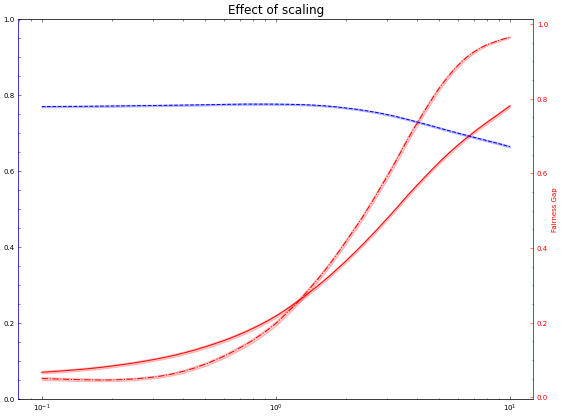

In [5]:
plt.figure(figsize=(8, 6))
ax2 = plt.gca().twinx()
ax1 = plt.gca()
sns.lineplot(
    data=all_results_df,
    x="weight",
    y="eo",
    label=r"$\Delta^{EO}$",
    err_style="band",
    errorbar=("se", 2),
    color="red",
    ax=ax2,
    linestyle="-.",
)
sns.lineplot(
    data=all_results_df,
    x="weight",
    y="dp",
    label=r"$\Delta^{DP}$",
    err_style="band",
    errorbar=("se", 2),
    color="red",
    ax=ax2,
)
sns.lineplot(
    data=all_results_df,
    x="weight",
    y="acc",
    label="Accuracy",
    err_style="band",
    errorbar=("se", 2),
    color="blue",
    ax=ax1,
    linestyle="--",
)
ax1.set_xlabel("Scaling factor")

ax1.set_ylabel("Accuracy", color="blue")
ax1.spines["left"].set_color("blue")
ax1.yaxis.label.set_color("blue")
ax1.tick_params(axis="y", colors="blue")

ax2.spines["right"].set_color("red")
ax2.set_ylabel("Fairness Gap", color="red")
ax2.yaxis.label.set_color("red")
ax2.tick_params(axis="y", colors="red")
ax1.set_xscale("log")
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(
    lines + lines2, labels + labels2, loc="upper right", bbox_to_anchor=(0.5, 0.7)
)
ax1.legend_.remove()
ax1.set_title("Effect of scaling")

plt.tight_layout()
plt.show()
